## Let's try RNN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
# import SummaryWriter
from torch.utils.tensorboard import SummaryWriter

random.seed(0)
torch.manual_seed(0)


In [2]:
# new data
DATA_DIR = "./evaluation dataset"
CSV_NAME = os.listdir(DATA_DIR)[0]
CSV_NAME

'fbcampus_alpha_8_run_2_merged.csv'

In [3]:
# change names
# for csv_path in os.listdir(DATA_DIR):
#     my_df = pd.read_csv(os.path.join(DATA_DIR, csv_path))
#     alpha = my_df["alpha"].unique()
#     print(alpha)
    # if csv_path.endswith(".csv"):
        # os.rename(os.path.join(DATA_DIR, csv_path), os.path.join(DATA_DIR, CSV_NAME))

## Merge CSVs

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, f'{CSV_NAME}'))

# df = df.dropna(axis=1) # to prevent nan in model output
df.head()


,noisy_motion_x,noisy_motion_y,noisy_motion_theta,noisy_motion_cov_xx,noisy_motion_cov_xy,noisy_motion_cov_xtheta,noisy_motion_cov_yy,noisy_motion_cov_ytheta,noisy_motion_cov_thetatheta,kalman_prediction_x,...,ground_truth_x,ground_truth_y,ground_truth_theta,alpha,ekf_pos_x,ekf_pos_y,ekf_pos_theta,ukf_pos_x,ukf_pos_y,ukf_pos_theta
0,3.947141e-07,-4.038279e-07,-0.000004,2.117079e-10,-2.165962e-10,-2.159547e-09,2.215973e-10,2.209410e-09,2.202866e-08,0.000932,...,-0.008753,-0.008753,0.311805,8,-0.000177,0.000692,0,-0.002842,0.004252,0.000039
1,-1.003149e-05,1.026401e-05,0.000102,2.101057e-10,-2.149758e-10,-2.143280e-09,2.199587e-10,2.192960e-09,2.186352e-08,0.000936,...,-0.008755,-0.008755,0.311823,8,-0.002016,0.003244,0,-0.000783,0.000251,0.000059
2,-1.980101e-05,2.026177e-05,0.000202,2.085195e-10,-2.133716e-10,-2.127177e-09,2.183366e-10,2.176675e-09,2.170005e-08,0.000920,...,-0.008757,-0.008757,0.311842,8,-0.001538,0.008422,0,-0.002654,-0.001761,0.000075
3,-4.373303e-06,4.475464e-06,0.000045,2.069492e-10,-2.117835e-10,-2.111235e-09,2.167308e-10,2.160554e-09,2.153821e-08,0.000928,...,-0.008759,-0.008759,0.311860,8,-0.003623,0.018208,0,-0.002173,-0.005682,0.000091
4,-1.707198e-05,1.747235e-05,0.000174,2.053945e-10,-2.102113e-10,-2.095453e-09,2.151412e-10,2.144595e-09,2.137799e-08,0.000918,...,-0.008761,-0.008761,0.311878,8,-0.002900,0.014161,0,-0.004066,-0.015467,0.000110


In [5]:
x = ["ground_truth_x", "ground_truth_y", "ground_truth_theta", 
     "kalman_prediction_x", "kalman_prediction_y", "kalman_prediction_theta", 
     'ekf_pos_x', 'ekf_pos_y', 'ekf_pos_theta', 
     'ukf_pos_x', 'ukf_pos_y', 'ukf_pos_theta']

In [6]:
features_df = df.drop(columns=x)
features_df.head()
# features_df.columns

,noisy_motion_x,noisy_motion_y,noisy_motion_theta,noisy_motion_cov_xx,noisy_motion_cov_xy,noisy_motion_cov_xtheta,noisy_motion_cov_yy,noisy_motion_cov_ytheta,noisy_motion_cov_thetatheta,lidar_x,lidar_y,lidar_theta,lidar_cov_xx,lidar_cov_xy,lidar_cov_xtheta,lidar_cov_yy,lidar_cov_ytheta,lidar_cov_thetatheta,alpha
0,3.947141e-07,-4.038279e-07,-0.000004,2.117079e-10,-2.165962e-10,-2.159547e-09,2.215973e-10,2.209410e-09,2.202866e-08,0.018041,-1.390618,0.024797,0.000005,0.000003,0,0.000006,0,6.467031e-08,8
1,-1.003149e-05,1.026401e-05,0.000102,2.101057e-10,-2.149758e-10,-2.143280e-09,2.199587e-10,2.192960e-09,2.186352e-08,0.015603,-1.387334,0.024770,0.000004,0.000002,0,0.000005,0,6.260201e-08,8
2,-1.980101e-05,2.026177e-05,0.000202,2.085195e-10,-2.133716e-10,-2.127177e-09,2.183366e-10,2.176675e-09,2.170005e-08,0.017814,-1.391149,0.024791,0.000004,0.000002,0,0.000005,0,6.323585e-08,8
3,-4.373303e-06,4.475464e-06,0.000045,2.069492e-10,-2.117835e-10,-2.111235e-09,2.167308e-10,2.160554e-09,2.153821e-08,0.016081,-1.393733,0.024715,0.000005,0.000003,0,0.000006,0,6.891506e-08,8
4,-1.707198e-05,1.747235e-05,0.000174,2.053945e-10,-2.102113e-10,-2.095453e-09,2.151412e-10,2.144595e-09,2.137799e-08,0.016931,-1.398638,0.024345,0.000005,0.000003,0,0.000007,0,6.836699e-08,8


In [7]:
len(df.columns), len(features_df.columns)

(31, 19)

## Columns for 2D case
- Kalman Predictions:
    - kalman_prediction_x
    - kalman_prediction_y
    - kalman_prediction_theta

- EKF:
    - ekf_pos_x 
    - ekf_pos_y 
    - ekf_pos_theta

- UKF:
    - ukf_pos_x 
    - ukf_pos_y 
    - ukf_pos_theta


- Ground Truth:
    - ground_truth_x
    - ground_truth_y
    - ground_truth_theta

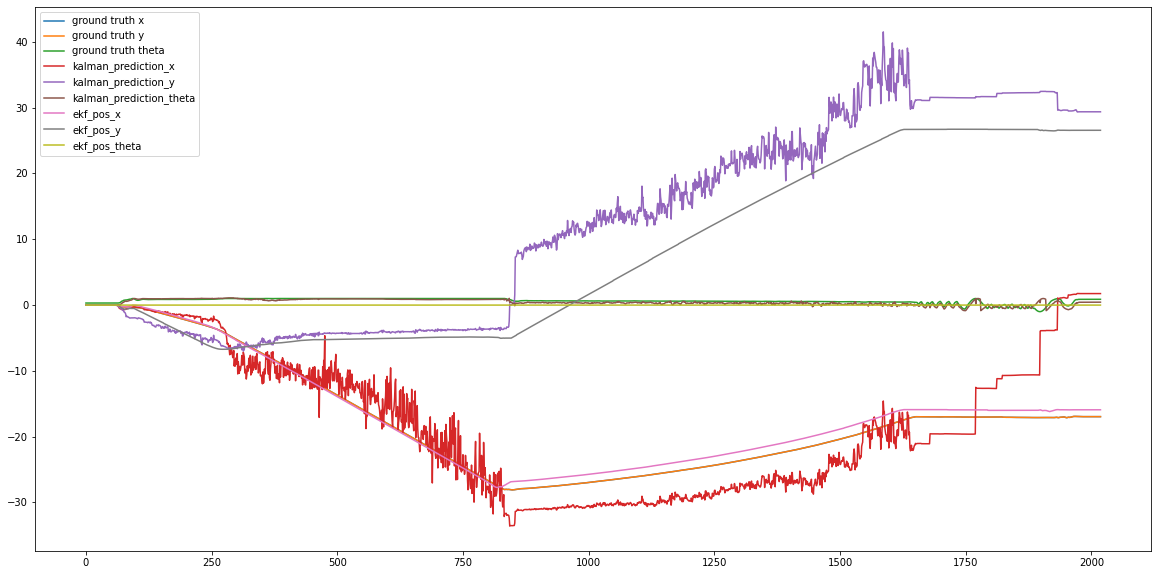

In [8]:
# Split
# train_df = df.sample(frac=0.8, random_state=0)
# test_df = df.drop(df.index)


# sanity checks
# kf_pred = torch.tensor(df['kalman prediction'].to_list()).reshape(-1, 1)
# gt = torch.tensor(df['ground truth'].to_list()).reshape(-1, 1)

split = -1


plt.figure(figsize=(20, 10))
plt.plot(df['ground_truth_x'].to_list()[:split])
plt.plot(df['ground_truth_y'].to_list()[:split])
plt.plot(df['ground_truth_theta'].to_list()[:split])

plt.plot(df['kalman_prediction_x'].to_list()[:split])
plt.plot(df['kalman_prediction_y'].to_list()[:split])
plt.plot(df['kalman_prediction_theta'].to_list()[:split])

plt.plot(df['ekf_pos_x'].to_list()[:split])
plt.plot(df['ekf_pos_y'].to_list()[:split])
plt.plot(df['ekf_pos_theta'].to_list()[:split])

plt.legend(['ground truth x', 'ground truth y', 'ground truth theta','kalman_prediction_x', 'kalman_prediction_y', 'kalman_prediction_theta', 'ekf_pos_x', 'ekf_pos_y', 'ekf_pos_theta'])
# plt.legend(['kalman prediction x', 'ground truth x', "kalman_pred_y","ground_truth_y", "kalman_prediction_theta",  "ground_truth_theta"])
plt.show()

In [9]:
# df[df.isna().values]

## Model

In [44]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, output_size=1 ):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    # def forward(self, x, h0):
    def forward(self, x):
        # h0 from the last batch

        # print(x.shape)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # print(h0.shape, torch.zeros(1, x.size(0), self.hidden_size).to(x.device).shape)
        out, _ = self.rnn(x, h0)
        if out.isnan().any():
            print("NAN:", out)
        fc_out = self.fc(out[:, -1, :]) # taking only the last hidden layer output
        # print(fc_out.shape, out.shape)
        if out.isnan().any():
            print("NAN: Second: ", out)
        return fc_out, out

## Reshape csv as per the seq length and batch size

In [35]:
def get_input_data(df, seq_len, batch_size, num_batches):

       labels = df[["ground_truth_x", "ground_truth_y", "ground_truth_theta" ]].to_numpy()
       kalman_pred = df[["kalman_prediction_x", "kalman_prediction_y", "kalman_prediction_theta"]].to_numpy() # used for comparison
       ekf_pred = df[["ekf_pos_x", "ekf_pos_y", "ekf_pos_theta"]].to_numpy() # used for comparison
       ukf_pred = df[["ukf_pos_x", "ukf_pos_y", "ukf_pos_theta"]].to_numpy() # used for comparison

       
       input_data_df = df[
              ['noisy_motion_x', 'noisy_motion_y', 'noisy_motion_theta',
              'noisy_motion_cov_xx', 'noisy_motion_cov_xy', 'noisy_motion_cov_xtheta',
              'noisy_motion_cov_yy', 'noisy_motion_cov_ytheta',
              'noisy_motion_cov_thetatheta', 'lidar_x', 'lidar_y', 'lidar_theta',
              'lidar_cov_xx', 'lidar_cov_xy', 'lidar_cov_xtheta', 'lidar_cov_yy',
              'lidar_cov_ytheta', 'lidar_cov_thetatheta', 'alpha']
       ].to_numpy()

       # input_data = input_data_df[:num_batches * batch_size]
       input_data = input_data_df.copy()

       # output_data = labels[:num_batches * batch_size]
       output_data = labels.copy()



       new_input_data = []
       new_output_data = []
       new_kp_data = []
       new_ekf_data = []
       new_ukf_data = []

       for i in range(len(input_data) - seq_len):
              new_input_data.append(input_data[i:i+seq_len])
              new_output_data.append(output_data[i + seq_len -1])
              new_kp_data.append(kalman_pred[i + seq_len -1])
              new_ekf_data.append(ekf_pred[i + seq_len -1])
              new_ukf_data.append(ukf_pred[i + seq_len -1])

       new_input_data = np.array(new_input_data[:num_batches* batch_size]) # drop the last batch
       new_output_data = np.array(new_output_data[:num_batches* batch_size]) # drop the last batch
       new_kp_data = np.array(new_kp_data[:num_batches* batch_size]) # drop the last batch
       new_ekf_data = np.array(new_ekf_data[:num_batches* batch_size]) # drop the last batch
       new_ukf_data = np.array(new_ukf_data[:num_batches* batch_size]) # drop the last batch

       return new_input_data, new_output_data, new_kp_data, new_ekf_data, new_ukf_data


In [36]:
seq_len = 10
batch_size = 10
num_batches = (len(df) - seq_len) // (batch_size)

new_input_data, new_output_data, kalman_pred_data, ekf_pred_data, ukf_pred_data =  get_input_data(df, seq_len = seq_len, batch_size = batch_size, num_batches = num_batches)


# new_input_data.shape == (num_batches* batch_size, seq_len, new_input_data.shape[-1])

In [37]:
new_input_data.shape, new_output_data.shape, kalman_pred_data.shape,  ekf_pred_data.shape, ukf_pred_data.shape

((2010, 10, 19), (2010, 3), (2010, 3), (2010, 3), (2010, 3))

In [38]:
# # sanity check
# print(new_input_data[0][-1], new_output_data[0].round(6))
print(df.iloc[seq_len - 1][["ground_truth_x", "ground_truth_y", "ground_truth_theta" ]].to_numpy(), new_output_data[0])
# == new_output_data[0].round(6)

# df.iloc[seq_len - 1]

[-0.00876944 -0.00876944  0.31196859] [-0.00876944 -0.00876944  0.31196859]


In [39]:
# split
# train_input_data = new_input_data[:num_batches* batch_size//2]
# train_output_data = new_output_data[:num_batches* batch_size//2]
# new_input_data[:len(new_input_data)*0.8, ].shape

test_idx = random.sample(range(len(new_input_data)), k = int(len(new_input_data)*0.2))
train_idx = [i for i in range(len(new_input_data)) if i not in test_idx]

test_input = new_input_data[test_idx]
test_output = new_output_data[test_idx]

train_input = new_input_data[train_idx]
train_output = new_output_data[train_idx].reshape(-1, 3)

train_kalman_pred = kalman_pred_data[train_idx]
test_kalman_pred = kalman_pred_data[test_idx]

train_ekf_pred = ekf_pred_data[train_idx]
test_ekf_pred = ekf_pred_data[test_idx]

train_ukf_pred = ukf_pred_data[train_idx]
test_ukf_pred = ukf_pred_data[test_idx]

In [40]:
train_input.shape, train_output.shape, test_input.shape, test_output.shape, train_kalman_pred.shape, test_kalman_pred.shape, train_ekf_pred.shape, test_ekf_pred.shape, train_ukf_pred.shape, test_ukf_pred.shape

((1608, 10, 19),
 (1608, 3),
 (402, 10, 19),
 (402, 3),
 (1608, 3),
 (402, 3),
 (1608, 3),
 (402, 3),
 (1608, 3),
 (402, 3))

In [41]:
# train_input.shape, train_output.shape, test_input.shape, test_output.shape

# train_input.shape, batch_size, (train_input.shape[0]//batch_size)*batch_size
# 

# get pytorch csv dataloader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_input).float(), torch.from_numpy(train_output).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_input).float(), torch.from_numpy(test_output).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False , drop_last=True)

## Gear Up | Train | Launch

In [47]:
input_size = train_input.shape[2]
output_size = train_output.shape[1]
hidden_size = 256
num_layers = 2
lr = 0.0001

writer = SummaryWriter(f"runs/RNN/seq_len_{seq_len}_batch_size_{batch_size}_hidden_size_{hidden_size}_lr_{lr}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleRNN(input_size=input_size, hidden_size = hidden_size, num_layers = num_layers, output_size = output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
criterion_l1 = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 0.0001, 0.0001, 1000)


In [48]:
# Train the model
loss_cache = []


num_epochs = 1
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output, hidden_output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    writer.add_scalar('training loss', loss, epoch)
    loss_cache.append(loss.item())
    # Print the loss after every epoch
    if epoch %5 ==0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [1/100], Loss: 40.5038
Epoch [6/100], Loss: 0.2780
Epoch [11/100], Loss: 6.5914
Epoch [16/100], Loss: 0.3471
Epoch [21/100], Loss: 0.8087
Epoch [26/100], Loss: 0.6713
Epoch [31/100], Loss: 0.2383
Epoch [36/100], Loss: 1.2223
Epoch [41/100], Loss: 1.0991
Epoch [46/100], Loss: 0.8120
Epoch [51/100], Loss: 0.3635
Epoch [56/100], Loss: 0.4183
Epoch [61/100], Loss: 0.5115
Epoch [66/100], Loss: 0.5221
Epoch [71/100], Loss: 0.3234
Epoch [76/100], Loss: 0.4542
Epoch [81/100], Loss: 0.4214
Epoch [86/100], Loss: 0.4823
Epoch [91/100], Loss: 0.3504
Epoch [96/100], Loss: 0.3560


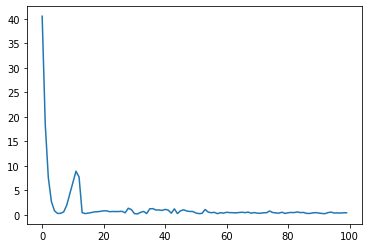

In [49]:
plt.plot(loss_cache)

## Pred

In [50]:
loss_cache = []
test_pred = []
with torch.no_grad():
    for inputs, outputs in test_loader:
        inputs = inputs.to(device)
        outputs = outputs.to(device).view(-1, 3)
        # outputs = outputs
        pred, _ = model(inputs)
        test_pred.append(pred)
        loss = criterion(pred, outputs)
        # print(loss.item())
        loss_cache.append(loss.item())

In [51]:
# Kalman filter prediction loss
loss_kp = criterion(torch.from_numpy(test_kalman_pred), torch.from_numpy(test_output))

loss_ekf = criterion(torch.from_numpy(test_ekf_pred), torch.from_numpy(test_output))
print("Test MSE RNN: {:.4f}".format(sum(loss_cache)))
print("Test MSE Kalman: {:.4f}".format(loss_kp))
print("Test MSE EKF: {:.4f}".format(loss_ekf))


Test MSE RNN: 204.8938
Test MSE Kalman: 446.1186
Test MSE EKF: 325.9876


In [52]:
# torch.stack(test_pred).reshape(-1, 3).shape

In [53]:
# test_output.shape, test_pred.shape
test_pred_y = torch.stack(test_pred).reshape(-1, 3)[:, 1].cpu().numpy()
test_pred_x = torch.stack(test_pred).reshape(-1, 3)[:, 0].cpu().numpy()
test_pred_theta = torch.stack(test_pred).reshape(-1, 3)[:, 2].cpu().numpy()

test_output_x = test_output[:, 0]
test_output_y = test_output[:, 1]
test_output_theta = test_output[:, 2]

kalman_pred_x = test_kalman_pred[:, 0]
kalman_pred_y = test_kalman_pred[:, 1]
kalman_pred_theta = test_kalman_pred[:, 2]

ekf_pred_x = test_ekf_pred[:, 0]
ekf_pred_y = test_ekf_pred[:, 1]
ekf_pred_theta = test_ekf_pred[:, 2]

ukf_pred_x = test_ukf_pred[:, 0]
ukf_pred_y = test_ukf_pred[:, 1]
ukf_pred_theta = test_ukf_pred[:, 2]

Text(0.5, 1.0, 'Theta')

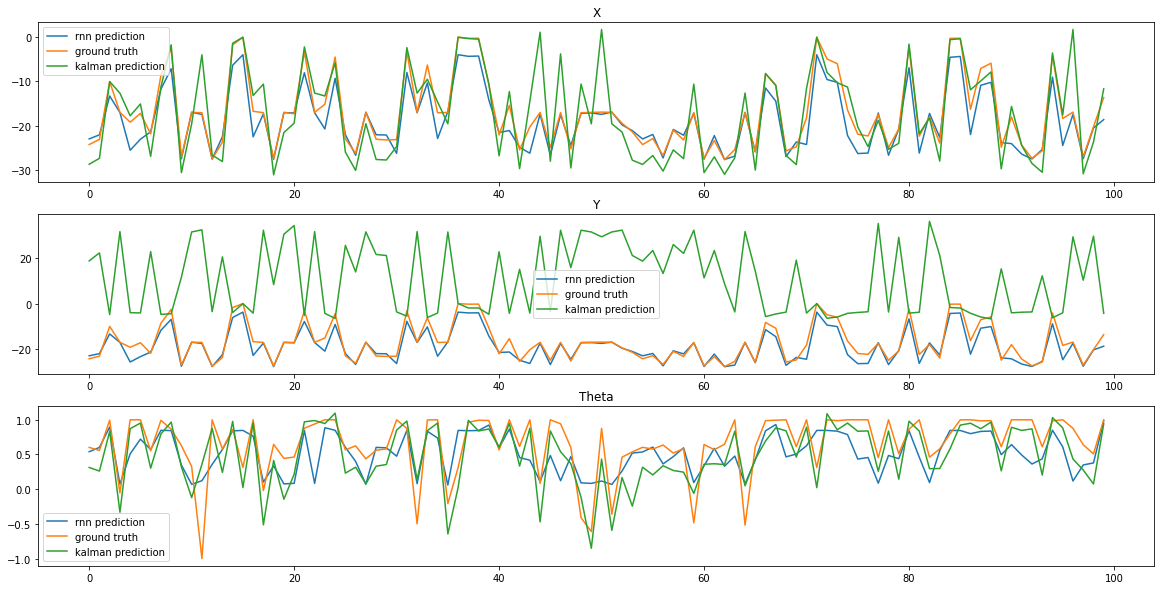

In [54]:
split = 100


plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.plot(test_pred_x[:split])
plt.plot(test_output_x[:split])
plt.plot(kalman_pred_x[:split])
plt.legend(['rnn prediction', 'ground truth', 'kalman prediction'])
plt.title("X")


plt.subplot(3, 1, 2)
plt.plot(test_pred_y[:split])
plt.plot(test_output_y[:split])
plt.plot(kalman_pred_y[:split])
plt.legend(['rnn prediction', 'ground truth', 'kalman prediction'])
plt.title("Y")

plt.subplot(3, 1, 3)
plt.plot(test_pred_theta[:split])
plt.plot(test_output_theta[:split])
plt.plot(kalman_pred_theta[:split])
plt.legend(['rnn prediction', 'ground truth', 'kalman prediction'])
plt.title("Theta")



Text(0.5, 1.0, 'Theta')

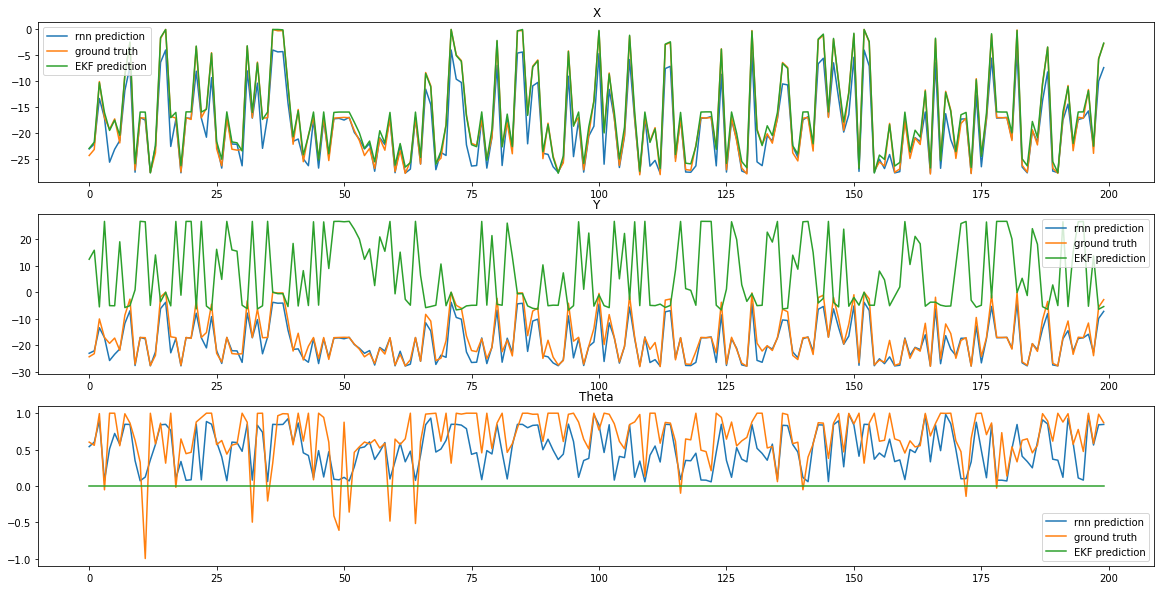

In [55]:
split = 200


plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.plot(test_pred_x[:split])
plt.plot(test_output_x[:split])
plt.plot(ekf_pred_x[:split])
plt.legend(['rnn prediction', 'ground truth', 'EKF prediction'])
plt.title("X")


plt.subplot(3, 1, 2)
plt.plot(test_pred_y[:split])
plt.plot(test_output_y[:split])
plt.plot(ekf_pred_y[:split])
plt.legend(['rnn prediction', 'ground truth', 'EKF prediction'])
plt.title("Y")

plt.subplot(3, 1, 3)
plt.plot(test_pred_theta[:split])
plt.plot(test_output_theta[:split])
plt.plot(ekf_pred_theta[:split])
plt.legend(['rnn prediction', 'ground truth', 'EKF prediction'])
plt.title("Theta")



In [62]:
def save_checkpoint(checkpoint):
    model_save_dir = f'./results/{CSV_NAME}'
    # print(model_save_dir)
    os.makedirs(model_save_dir, exist_ok=True)
    # chckpoint = {
    #     'epoch': num_epochs,
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'loss': torch.tensor(loss_cache),
    # }

    torch.save(checkpoint, os.path.join(model_save_dir, "model.pt"))

## Setting up Ray Tune

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import ray
from ray import tune
# from ray.tune.examples.mnist_pytorch import get_data_loaders, ConvNet, train, test


In [61]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [62]:

# Define the training function
def train_rnn(config):
    model = RNNModel(config["input_size"], config["hidden_size"], config["num_layers"], config["output_size"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    # for epoch in range(config["epochs"]):
    #     for i, (images, labels) in enumerate(train_loader):
    #         images = images.to(device)
    #         labels = labels.to(device)
            
    #         optimizer.zero_grad()
    #         outputs = model(images)
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            output, hidden_output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

    # # Compute accuracy on validation set
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for images, labels in val_loader:
    #         images = images.to(device)
    #         labels = labels.to(device)
    #         outputs = model(images)
    #         _, predicted = torch.max(outputs.data, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()

    test_pred = []
    with torch.no_grad():
        for inputs, outputs in test_loader:
            inputs = inputs.to(device)
            outputs = outputs.to(device).view(-1, 3)
            # outputs = outputs
            pred, _ = model(inputs)
            test_pred.append(pred)
            loss = criterion(pred, outputs)
            # print(loss.item())

    # accuracy = 100 * correct / total
    inverse_MSE = len(loss_cache) / sum(loss_cache) # using inverse MSE as the metric
    tune.report(accuracy=inverse_MSE)


In [63]:

# Define the search space
config = {
    "input_size": tune.choice([28, 32, 36]),
    "hidden_size": tune.choice([64, 128, 256]),
    "num_layers": tune.choice([1, 2, 3]),
    "output_size": train_output.shape[1],
    "lr": tune.loguniform(1e-4, 1e-1),
    "epochs": 10
}

# Set up data loaders
# train_loader, val_loader, test_loader = get_data_loaders()

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [65]:

# Set up Ray Tune
try:
    ray.init()
except:
    pass
analysis = tune.run(train_rnn, config=config, num_samples=10)

2023-04-26 22:41:44,807	ERROR trial_runner.py:1450 -- Trial train_rnn_f7fe3_00006: Error happened when processing _ExecutorEventType.TRAINING_RESULT.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=32523, ip=10.127.30.27, repr=train_rnn)
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/ray/tune/trainable/trainable.py", line 384, in train
    raise skipped from exception_cause(skipped)
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/ray/tune/trainable/function_trainable.py", line 336, in entrypoint
    return self._trainable_func(
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/ray/tune/trainable/function_trainable.py", line 653, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_4121359/2493076481.py", line 3, in train_rnn
  File "/home/anees.hashmi/.conda/envs/main/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1145, in to
    return self._apply(convert)
  File 

Trial name,date,hostname,node_ip,pid,timestamp,trial_id
train_rnn_f7fe3_00006,2023-04-26_22-41-44,ws-l2-001,10.127.30.27,32523,1682534504,f7fe3_00006


TuneError: ('Trials did not complete', [train_rnn_f7fe3_00000, train_rnn_f7fe3_00001, train_rnn_f7fe3_00002, train_rnn_f7fe3_00003, train_rnn_f7fe3_00004, train_rnn_f7fe3_00005, train_rnn_f7fe3_00006, train_rnn_f7fe3_00007, train_rnn_f7fe3_00008, train_rnn_f7fe3_00009])

In [ ]:

# # Get best hyperparameters and train model with them
# best_config = analysis.get_best_config(metric="accuracy")
# model = RNNModel(best_config["input_size"], best_config["hidden_size"], best_config["num_layers"], best_config["num_classes"]).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=best_config["lr"])
# for epoch in range(best_config["epochs"]):
#     train(model, optimizer, criterion, train_loader, device)
# test_acc = test(model, test_loader, device)
# print("Test accuracy:", test_acc)
